In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from scipy.stats import ttest_1samp

In [57]:
data_path = 'data/'

timeframe = 'monthly'
stat = ''

if timeframe == 'quarterly':
    timescale = 4
elif timeframe == 'monthly':
    timescale = 1

In [58]:
total = pd.read_csv(data_path + f'total_{timeframe}{stat}.csv', delimiter=',', header=0, encoding='latin-1')
total['date'] = pd.to_datetime(total['date'])
total

,country,date,co2_m,pop_m,gdp_m,co2_m_cap,gdp_m_cap
0,Austria,2000-01-01,9726927.646,8003000.0,2.309478e+11,1.215410,28857.653380
1,Austria,2000-02-01,8532685.059,8004700.0,2.321217e+11,1.065959,28998.180236
2,Austria,2000-03-01,8134567.013,8006400.0,2.332957e+11,1.016008,29138.647415
3,Austria,2000-04-01,6546737.758,8008100.0,2.344696e+11,0.817514,29279.054957
4,Austria,2000-05-01,5603261.736,8010100.0,2.352176e+11,0.699525,29365.122366
...,...,...,...,...,...,...,...
4555,Switzerland,2019-08-01,2793634.688,8589980.0,6.281104e+11,0.325220,73121.285498
4556,Switzerland,2019-09-01,3445179.636,8593460.0,6.291429e+11,0.400907,73211.821548
4557,Switzerland,2019-10-01,3819263.405,8596940.0,6.301753e+11,0.444258,73302.284301
4558,Switzerland,2019-11-01,4487169.820,8600420.0,6.312078e+11,0.521738,73392.673846


In [59]:
# total_lag = total.copy()

# for col in total_lag.columns[2:]:
#     val = total_lag.set_index('date').groupby('country').resample('MS').asfreq()[col]
#     val  = val.groupby(level=0).shift(1)
#     total_lag[f'{col}_lag'] = total_lag.set_index(['country', 'date']).index.map(val)

# total_lag = total_lag.dropna(axis=0, how='any')
# total_lag = total_lag.reset_index(drop=True)
# total_lag

In [60]:
target_countries = ['Iceland', 'Ireland', 'France', 'Portugal', 'Switzerland']

donor_countries = ['Austria', 'Belgium', 'Bulgaria', 
#                    'Cyprus', 
                   'Croatia', 'Czech Republic',
                   'Germany', 'Greece', 'Hungary', 'Italy', 'Lithuania', 'Netherlands', 
                   'Romania', 'Slovakia', 'Spain']

incl_years = pd.to_datetime(total['date']).dt.year.unique()
print(list(incl_years))
incl_countries = target_countries + donor_countries
incl_countries.sort()
print(len(incl_countries))
print(incl_countries)

[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
19
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Lithuania', 'Netherlands', 'Portugal', 'Romania', 'Slovakia', 'Spain', 'Switzerland']


In [61]:
target_country = 'France'
target_var = f'co2_{timeframe}{stat}'
impl_year = 2014

print(len(donor_countries))
print(donor_countries)

14
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'Germany', 'Greece', 'Hungary', 'Italy', 'Lithuania', 'Netherlands', 'Romania', 'Slovakia', 'Spain']


In [71]:
donors = total.copy()
donors = donors[donors['country'].isin(donor_countries)].reset_index(drop=True)
donors = donors.pivot(index='date',columns=['country'], values=[f'pop_m{stat}'])
donors.columns = donors.columns.to_flat_index()
donors.columns = [str(col_name[1]) + ' '+ str(col_name[0]) for col_name in donors.columns]
donors = donors.reindex(sorted(donors.columns), axis=1)
donors = donors.dropna(axis=1)
donors

,Austria pop_m,Belgium pop_m,Bulgaria pop_m,Croatia pop_m,Czech Republic pop_m,Germany pop_m,Greece pop_m,Hungary pop_m,Italy pop_m,Lithuania pop_m,Netherlands pop_m,Romania pop_m,Slovakia pop_m,Spain pop_m
date,,,,,,,,,,,,,,
2000-01-01,8003000.0,1.024200e+07,8.184100e+06,4.508700e+06,1.027400e+07,8.145200e+07,1.078330e+07,1.021710e+07,5.692900e+07,3499500.0,15880000.0,22455700.0,5.398900e+06,4.047860e+07
2000-02-01,8004700.0,1.024367e+07,8.180967e+06,4.503733e+06,1.027333e+07,8.145267e+07,1.078823e+07,1.021517e+07,5.693187e+07,3499500.0,15889000.0,22452700.0,5.399333e+06,4.049453e+07
2000-03-01,8006400.0,1.024533e+07,8.177833e+06,4.498767e+06,1.027267e+07,8.145333e+07,1.079317e+07,1.021323e+07,5.693473e+07,3499500.0,15898000.0,22449700.0,5.399767e+06,4.051047e+07
2000-04-01,8008100.0,1.024700e+07,8.174700e+06,4.493800e+06,1.027200e+07,8.145400e+07,1.079810e+07,1.021130e+07,5.693760e+07,3499500.0,15907000.0,22446700.0,5.400200e+06,4.052640e+07
2000-05-01,8010100.0,1.024900e+07,8.170367e+06,4.488867e+06,1.027200e+07,8.145567e+07,1.080317e+07,1.020947e+07,5.694053e+07,3499500.0,15918000.0,22445000.0,5.400600e+06,4.054413e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,8884920.0,1.149940e+07,6.984720e+06,4.063940e+06,1.067860e+07,8.311400e+07,1.072050e+07,9.766500e+06,5.969648e+07,2794100.0,17364800.0,19401980.0,5.454640e+06,4.717334e+07
2019-09-01,8887840.0,1.150280e+07,6.980640e+06,4.063080e+06,1.068120e+07,8.312200e+07,1.072020e+07,9.766600e+06,5.969066e+07,2794100.0,17372600.0,19395760.0,5.455080e+06,4.719698e+07
2019-10-01,8890760.0,1.150620e+07,6.976560e+06,4.062220e+06,1.068380e+07,8.313000e+07,1.071990e+07,9.766700e+06,5.968484e+07,2794100.0,17380400.0,19389540.0,5.455520e+06,4.722062e+07


In [72]:
for col in donors.columns:
    donor_series = donors[col]
    adf_test = adfuller(donor_series)
    if adf_test[1] < 0.05:
#         print(f'{col}: Stationary')
        pass
    if adf_test[1] >= 0.05:
        print(f'{col}: Non-stationary ({adf_test[1]})')
#         donors = donors.drop(col, axis=1)

Austria pop_m: Non-stationary (0.9827498531294232)
Belgium pop_m: Non-stationary (0.811619041707625)
Bulgaria pop_m: Non-stationary (0.4134445702997761)
Croatia pop_m: Non-stationary (0.45248489048857116)
Czech Republic pop_m: Non-stationary (0.6382690328019299)
Germany pop_m: Non-stationary (0.28677040419743416)
Greece pop_m: Non-stationary (0.45695234610402086)
Hungary pop_m: Non-stationary (0.6295422199324243)
Italy pop_m: Non-stationary (0.06755945420597283)
Lithuania pop_m: Non-stationary (0.4853919932392301)
Netherlands pop_m: Non-stationary (0.999041040912542)
Slovakia pop_m: Non-stationary (0.9558831776460103)


In [73]:
donors

,Austria pop_m,Belgium pop_m,Bulgaria pop_m,Croatia pop_m,Czech Republic pop_m,Germany pop_m,Greece pop_m,Hungary pop_m,Italy pop_m,Lithuania pop_m,Netherlands pop_m,Romania pop_m,Slovakia pop_m,Spain pop_m
date,,,,,,,,,,,,,,
2000-01-01,8003000.0,1.024200e+07,8.184100e+06,4.508700e+06,1.027400e+07,8.145200e+07,1.078330e+07,1.021710e+07,5.692900e+07,3499500.0,15880000.0,22455700.0,5.398900e+06,4.047860e+07
2000-02-01,8004700.0,1.024367e+07,8.180967e+06,4.503733e+06,1.027333e+07,8.145267e+07,1.078823e+07,1.021517e+07,5.693187e+07,3499500.0,15889000.0,22452700.0,5.399333e+06,4.049453e+07
2000-03-01,8006400.0,1.024533e+07,8.177833e+06,4.498767e+06,1.027267e+07,8.145333e+07,1.079317e+07,1.021323e+07,5.693473e+07,3499500.0,15898000.0,22449700.0,5.399767e+06,4.051047e+07
2000-04-01,8008100.0,1.024700e+07,8.174700e+06,4.493800e+06,1.027200e+07,8.145400e+07,1.079810e+07,1.021130e+07,5.693760e+07,3499500.0,15907000.0,22446700.0,5.400200e+06,4.052640e+07
2000-05-01,8010100.0,1.024900e+07,8.170367e+06,4.488867e+06,1.027200e+07,8.145567e+07,1.080317e+07,1.020947e+07,5.694053e+07,3499500.0,15918000.0,22445000.0,5.400600e+06,4.054413e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,8884920.0,1.149940e+07,6.984720e+06,4.063940e+06,1.067860e+07,8.311400e+07,1.072050e+07,9.766500e+06,5.969648e+07,2794100.0,17364800.0,19401980.0,5.454640e+06,4.717334e+07
2019-09-01,8887840.0,1.150280e+07,6.980640e+06,4.063080e+06,1.068120e+07,8.312200e+07,1.072020e+07,9.766600e+06,5.969066e+07,2794100.0,17372600.0,19395760.0,5.455080e+06,4.719698e+07
2019-10-01,8890760.0,1.150620e+07,6.976560e+06,4.062220e+06,1.068380e+07,8.313000e+07,1.071990e+07,9.766700e+06,5.968484e+07,2794100.0,17380400.0,19389540.0,5.455520e+06,4.722062e+07


In [74]:
X_cols = list(donors.columns)
X_orig = donors[X_cols]

y = np.array(total[total['country']==target_country][target_var]).reshape(-1,1)
X = np.array(donors[X_cols])

### Sandardization of data ###
PredictorScaler = StandardScaler()
TargetVarScaler = StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X)
TargetVarScalerFit = TargetVarScaler.fit(y)

# Generating the standardized values of X and y
X = PredictorScalerFit.transform(X)
y = TargetVarScalerFit.transform(y)
 
# Split the data into training and testing set
ts = int((2019 - impl_year + 1)*(12/timescale))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)
 
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(168, 14)
(168, 1)
(72, 14)
(72, 1)


Text(0, 0.5, 'weights')

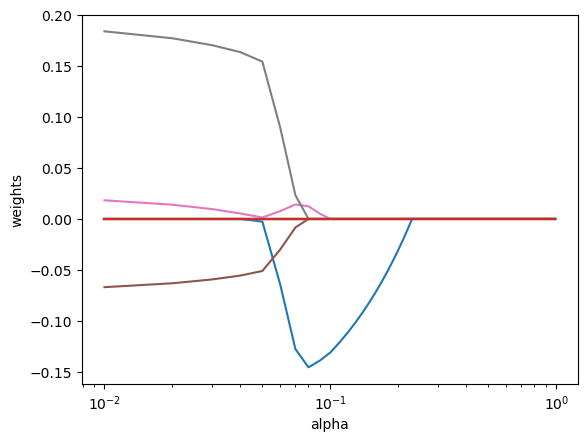

In [75]:
alphas = np.arange(0.01,1,0.01)

lasso = Lasso(max_iter=10000)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [76]:
# define model evaluation method
tscv = TimeSeriesSplit(n_splits=round(len(X_train)/5))
# define model
model = LassoCV(
                alphas=np.arange(0.01, 2, 0.001), 
#                 alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                cv=tscv,
                fit_intercept=True,
                max_iter=100000,
                tol=0.00001
               )
# fit model
model.fit(X_train, y_train.ravel())
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
print(model)

alpha: 0.084000
LassoCV(alphas=array([0.01 , 0.011, 0.012, ..., 1.997, 1.998, 1.999]),
        cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=34, test_size=None),
        max_iter=100000, tol=1e-05)


In [77]:
# print(model.alpha_)
# print(model.coef_X)
# print(model.intercept_)
# print(model.score)
# print(model.get_params)

coefs = list(model.coef_)
coef_index = [i for i, val in enumerate(coefs) if val != 0]
coef_index

print(len(X_orig.columns[coef_index]))
print(X_orig.columns[coef_index])

coeffs = model.coef_
print(coeffs[coeffs != 0])

2
Index(['Austria pop_m', 'Greece pop_m'], dtype='object')
[-0.14297591  0.00944193]


In [78]:
model.score(X_train, y_train)

0.047644173277810675

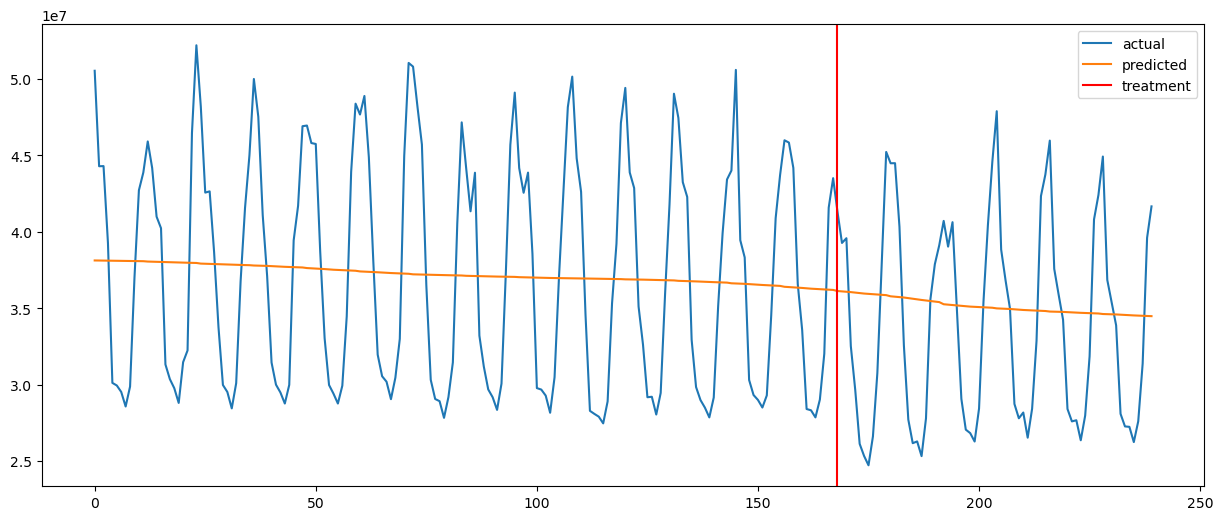

In [79]:
x_ax = X_orig.index
act = TargetVarScalerFit.inverse_transform(y)
pred = TargetVarScalerFit.inverse_transform(model.predict(X).reshape(-1, 1))

plt.figure(figsize=(15,6))
plt.plot(act, label='actual')
plt.plot(pred, label='predicted')
plt.axvline(x = impl_year/(12*timescale), c='r', label='treatment')
plt.legend()
plt.plot();

[-15831388.05196035]
[-86557277.05337958]


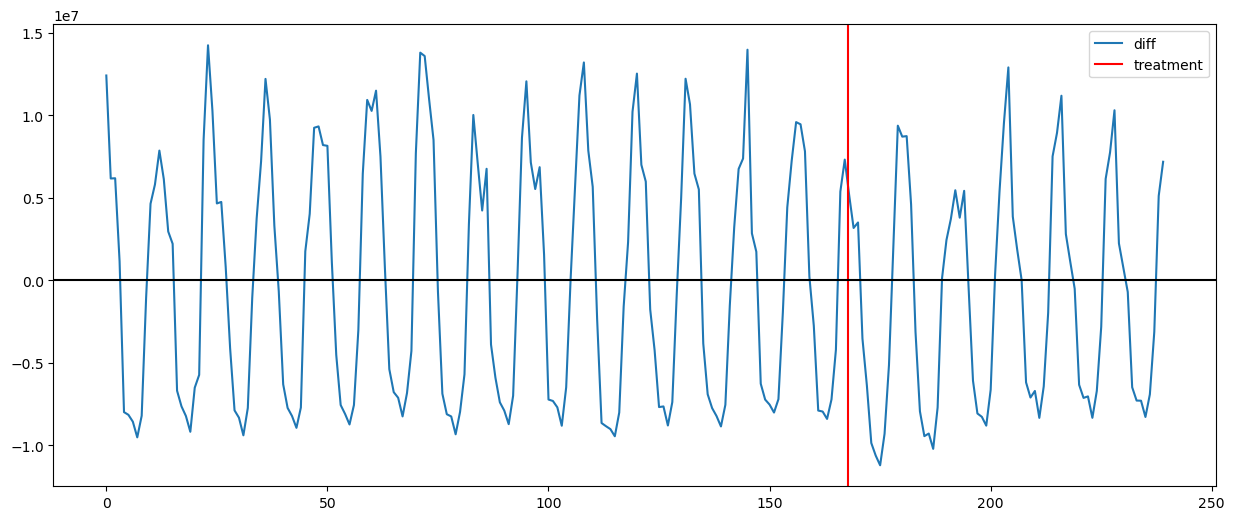

In [80]:
diff = act - pred
print(sum(diff[:round(impl_year/(12*timescale))]))
print(sum(diff[round(impl_year/(12*timescale)):]))

plt.figure(figsize=(15,6))
plt.plot(diff, label='diff')
plt.axvline(x = impl_year/(12*timescale), c='r', label='treatment')
plt.axhline(y=0, c='black')
plt.legend()
plt.plot();

In [81]:
res = ttest_1samp(diff[round(impl_year/(12*timescale)):], popmean=0)
print(res)

ci = res.confidence_interval(confidence_level=0.95)
print(ci)

TtestResult(statistic=array([-1.52839789]), pvalue=array([0.13085692]), df=array([71]))
ConfidenceInterval(low=array([-2770550.62505313]), high=array([366181.81801481]))


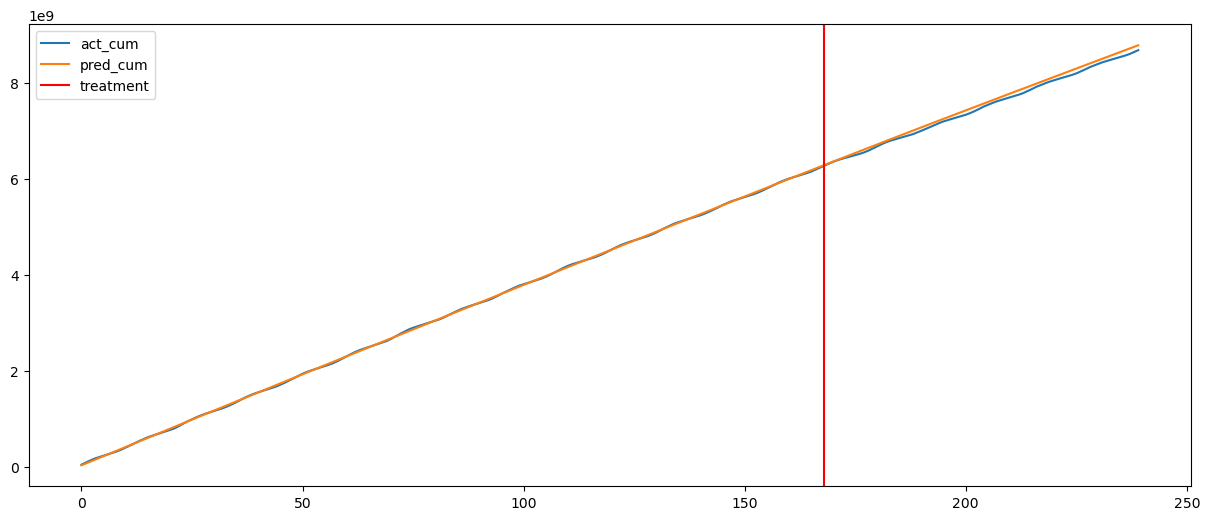

In [82]:
act_cum = np.cumsum(act)
pred_cum = np.cumsum(pred)

# act_cum = np.cumsum(act[round(impl_year/12):])
# pred_cum = np.cumsum(pred[round(impl_year/12):])

plt.figure(figsize=(15,6))
plt.plot(act_cum, label='act_cum')
plt.plot(pred_cum, label='pred_cum')
plt.axvline(x = impl_year/(12*timescale), c='r', label='treatment')
plt.legend()
plt.plot();